<a href="https://colab.research.google.com/github/anerdygirl/CTF365/blob/master/KITTI_Mapping_Tutorial_Step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REFERENCES

[1] Repository for this tutorial: https://github.com/MukhlasAdib/KITTI_Mapping.

[2] The full KITTI datased can be accessed here: http://www.cvlibs.net/datasets/kitti/.

[3] KITTI Dataset paper: A. Geiger, P. Lenz, C. Stiller and R. Urtasun, "Vision meets Robotics: The KITTI Dataset," *International Journal of Robotics Research (IJRR)*, vol. 32, no. 11, pp. 1231-1237 2013.

[4] Description of Occupancy Grid Map (OGM) estimation: Z. Luo, M. V. Mohrenschilt and S. Habibi, "A probability occupancy grid based approach for real-time LiDAR ground segmentation," *IEEE Transactions on Intelligent Transportation Systems*, vol 21, no. 3, pp. 998–1010, Mar. 2020.

[5] Description of Dynamic Grid Map (DGM) estimation: J. Moras, V. Cherfaoui and P. Bonnifait, "Credibilist occupancy grids for vehicle perception in dynamic environments," *2011 IEEE International Conference on Robotics and Automation*, Shanghai, China, 2011, pp. 84-89.

[6] Paper of DeepLab v3+ for image segmentation: L. C. Chen, Y. Zhu, G. Apandreou, F. Schroff and H. Adam, “Encoder-decoder with atrous separable convolution for semantic image segmentation,” *ECCV 2018 Lecture Notes in Computer Science*, vol. 11211, pp. 833–851, 2018.

[7] DeepLab v3+ paper via arXiv: https://arxiv.org/abs/1802.02611.

[8] DeepLab v3+ repository: https://github.com/tensorflow/models/tree/master/research/deeplab.

[9] This tutorial use pykitti module to load the KITTI dataset: https://github.com/utiasSTARS/pykitti.

# PREPARATION

In [1]:
!git clone https://github.com/MukhlasAdib/KITTI_Mapping.git
!pip install pykitti
!pip install opencv-python==3.4.18.65 scipy==1.7.3

Cloning into 'KITTI_Mapping'...
remote: Enumerating objects: 1027, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1027 (delta 60), reused 122 (delta 56), pack-reused 894 (from 1)
Receiving objects: 100% (1027/1027), 533.41 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Updating files: 100% (464/464), done.
ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version 

In [2]:
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pykitti
import tensorflow as tf
from sklearn.linear_model import RANSACRegressor
from scipy import stats

In [3]:
### Load KITTI Data
basedir = 'KITTI_Mapping/raw_data/'
date = '2011_09_26'
drive = '0013'
data = pykitti.raw(basedir, date, drive)

### Index of data used for test
### We use two data from different time
idx = 50
idx1 = idx+10

# PERCEPTION

The goal of the perception system is to extract the information about the round where the vehicle is operating on. This road information will be used to filter out LiDAR points that hit the road so that it can be used for mapping purpose. To extract the information about where the road is, we use deep learning-based image segmentation technique that will be applied to the camera image.

## Get Callibration Data

Two callibrated parameters that we need:
- LiDAR to camera extrinsic matrix - The matrix (4x4) that will be used to transform the LiDAR points to the camera 3D coordinate frame.
-  Camera intrinsic matrix - The mastrix (3x3) that will be used to calculate the coordinate of pixels that representat 3D points in camera coordinate.

The calibrated parameters are already provided in the dataset. For details, please take a look at [this explanation](https://www.mathworks.com/help/vision/ug/camera-calibration.html) from Mathworks.

In [9]:
### Retrieve the provided calibration data
lidar2cam_extrinsic = data.calib.T_cam2_velo
camera_intrinsic = data.calib.K_cam2

print('Lidar to camera extrinsic matrix: ')
print(lidar2cam_extrinsic)
print()
print('Camera intrinsic matrix: ')
print(camera_intrinsic)

Lidar to camera extrinsic matrix: 
[[ 2.34773698e-04 -9.99944155e-01 -1.05634778e-02  5.93721868e-02]
 [ 1.04494074e-02  1.05653536e-02 -9.99889574e-01 -7.51087914e-02]
 [ 9.99945389e-01  1.24365378e-04  1.04513030e-02 -2.72132796e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera intrinsic matrix: 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]


## Load Camera and LiDAR Data

Coordinate system of
- Camera = x: right, y: down, z: forward
- LiDAR = x: forward, y: left, z: up

In this tutorial, camera coordinate system is used. Therefore, the LiDAR points need to be transformed to the camera coordinate frame. Use the LiDAR to camera extrinsic matrix!

The extrinsic matrix can be written as $\begin{bmatrix} R|t \end{bmatrix}$, a combinarion of a rotation matrix $R$ and a translation vector $t$. Given that the point in LiDAR coordinate is $(X_L,Y_L,Z_L)$, its coordinate in camera 3D frame, $(X_C,Y_C,Z_C)$ is

\begin{align}
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
1 \\
\end{bmatrix}=
\begin{bmatrix} R|t \end{bmatrix}
\begin{bmatrix}
X_L \\
Y_L \\
Z_L \\
1 \\
\end{bmatrix}
\end{align}



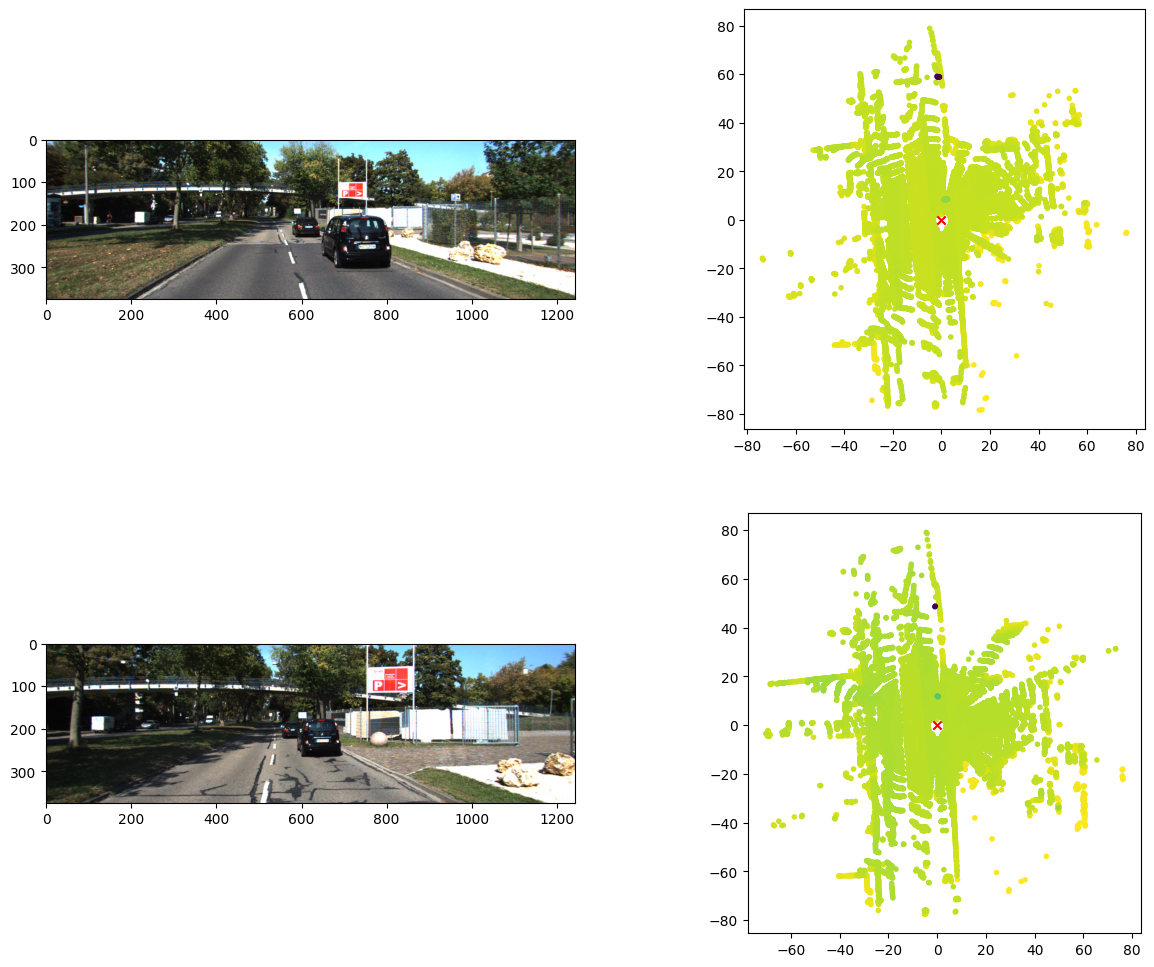

In [5]:
def load_data(data,idx):
  ### Get the image data
  img_raw = np.array(data.get_cam2(idx))

  ### Get the LiDAR data (only x,y,z data)
  ### Only use LiDAR points that are below the sensor
  ### Only use LiDAR points that are at least 2.5 m away
  lidar_raw = np.array(data.get_velo(idx))[:,:3]
  lidar_raw = lidar_raw[lidar_raw[:,2]<=0,:]
  dist = np.linalg.norm(lidar_raw,axis=1)
  lidar_raw = lidar_raw[dist >= 2.5]
  return img_raw,lidar_raw

### Transform the LiDAR points into camera coordinate
def transform_coordinate(lidar_points,extrinsic_matrix):
  inp = lidar_points.copy()
  inp = np.concatenate((inp,np.ones((inp.shape[0],1))),axis=1)
  inp = np.matmul(extrinsic_matrix,inp.T).T
  return inp[:,:3]

img_raw,lidar_raw = load_data(data,idx)
img_raw_size = img_raw.shape
lidar_raw = transform_coordinate(lidar_raw,lidar2cam_extrinsic)

img_raw1,lidar_raw1 = load_data(data,idx1)
img_raw1_size = img_raw1.shape
lidar_raw1 = transform_coordinate(lidar_raw1,lidar2cam_extrinsic)

### Visualize
fig,axs = plt.subplots(2,2,figsize=(15,12))
axs[0,0].imshow(img_raw)
axs[0,1].scatter(lidar_raw[:,0],lidar_raw[:,2],c=-lidar_raw[:,1],marker='.')
axs[0,1].scatter(0,0,c='r',marker='x')
axs[0,1].axis('scaled')
axs[1,0].imshow(img_raw1)
axs[1,1].scatter(lidar_raw1[:,0],lidar_raw1[:,2],c=-lidar_raw1[:,1],marker='.')
axs[1,1].scatter(0,0,c='r',marker='x')
axs[1,1].axis('scaled')
plt.show()

## Project the LiDAR Points to the Camera

To transfer the road information from image to LiDAR, we need to project the LiDAR points to the camera image. Use the camera intrinsic matrix!

The camera intrinsic matrix is denoted as $K$. The coordinate of pixel, $(u,v)$, that represents a point in 3D space, $(X_C,Y_C,Z_C)$, in image frame can be calculated with

\begin{align}
\begin{bmatrix}
u\times w \\
v\times w \\
w \\
\end{bmatrix}=
K
\begin{bmatrix}
X_C \\
Y_C \\
Z_C \\
\end{bmatrix}
\end{align}

<br>
<center><img src="https://docs.opencv.org/4.5.0/pinhole_camera_model.png" width=400px></center>
</br>

Sumber gambar: [OpenCV Docs](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html)

Original image size: (375, 1242, 3)


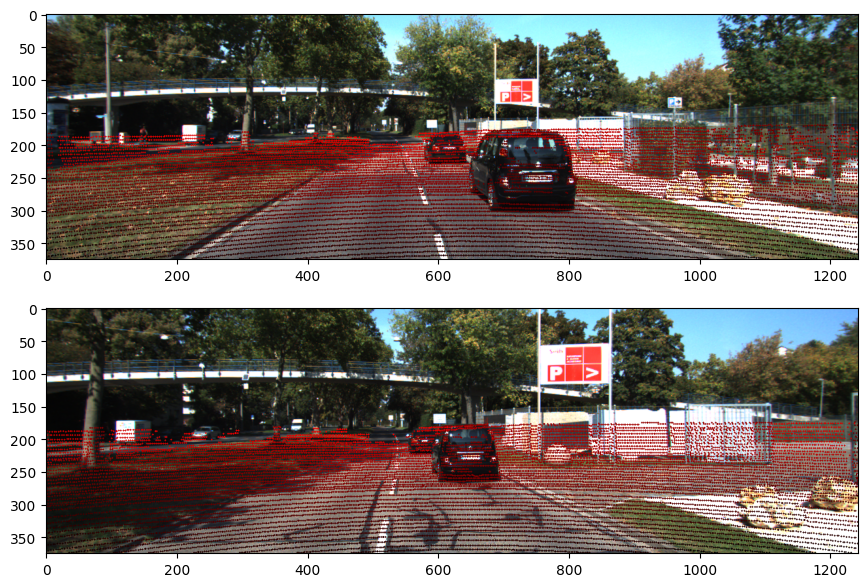

In [6]:
def project_lidar2cam(lidar_in_cam,camera_intrinsic,img_raw_size):
  ### Filter out data behind the cam
  lidar_in_cam = np.concatenate((lidar_in_cam,np.ones((lidar_in_cam.shape[0],1))),axis=1)
  lidar_in_cam = lidar_in_cam[lidar_in_cam[:,2]>0]

  ### Project points to the image
  lidar_2d = np.matmul(camera_intrinsic,lidar_in_cam[:,:3].T).T
  lidar_2d = np.divide(lidar_2d,lidar_2d[:,2].reshape((-1,1)))
  lidar_2d = lidar_2d.astype(int)

  ### Filter out points that are outside image frame
  maskH = np.logical_and(lidar_2d[:,0]>=0,lidar_2d[:,0]<img_raw_size[1])
  maskV = np.logical_and(lidar_2d[:,1]>=0,lidar_2d[:,1]<img_raw_size[0])
  mask = np.logical_and(maskH,maskV)
  lidar_2d = lidar_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]

  return lidar_2d,lidar_in_cam[:,:3]

lidar_2d,lidar_in_cam = project_lidar2cam(lidar_raw,camera_intrinsic,img_raw_size)
lidar_2d1,lidar_in_cam1 = project_lidar2cam(lidar_raw1,camera_intrinsic,img_raw_size)

### Visualize
print(f'Original image size: {img_raw.shape}')

img = img_raw.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = img_raw1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(2,1,figsize=(15,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Image Cropping

The deep learning model (DeepLab v3+) was trained with cropped images from KITTI dataset with ratio 4:3 (W:H), which was resized further to 513 x 513 images. It will work better if we use the same size of images.

Parameter:
- CROP_RH - The height ratio of target image size
- CROP_RW - The width ratio of target image size

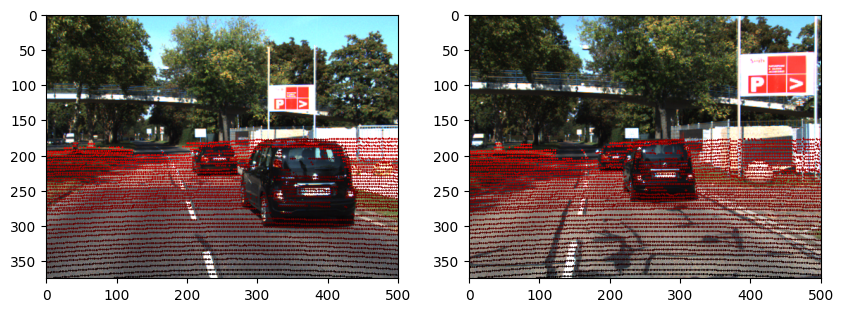

In [7]:
### Function to crop the image according to the target size ratio
### The image will be cropped at the center
def crop_data(img_in,lidar_2d_in,lidar_in_cam_in,rh,rw):
  lidar_2d = lidar_2d_in.copy()
  lidar_in_cam = lidar_in_cam_in.copy()
  img = img_in.copy()

  ### Crop the image
  dim_ori = np.array(img.shape)
  cent = (dim_ori/2).astype(int)
  if dim_ori[0]/dim_ori[1] == rh/rw:
      crop_img = img

  # If Height <= Width
  elif dim_ori[0] <= dim_ori[1]:
      cH2 = dim_ori[0]
      cW2 = cH2*rw/rh
      cW = int(cW2/2)
      crop_img = img[:,cent[1]-cW:cent[1]+cW+1]

  # If Height > Width
  else:
      cW2 = dim_ori[1]
      cH2 = cW2*rh/rw
      cH = int(cH2/2)
      crop_img = img[cent[0]-cH:cent[0]+cH+1,:]

  ### Filter out LiDAR points outside cropped image
  cW = cW2/2
  cH = cH2/2
  centH = cent[0]
  centW = cent[1]
  maskH = np.logical_and(lidar_2d[:,1]>=centH-cH,lidar_2d[:,1]<=centH+cH)
  maskW = np.logical_and(lidar_2d[:,0]>=centW-cW,lidar_2d[:,0]<=centW+cW)
  mask = np.logical_and(maskH,maskW)
  lidar_2d = lidar_2d[mask,:]
  lidar_in_cam = lidar_in_cam[mask,:]
  cent = np.array((centW-cW,centH-cH,0)).reshape((1,3))
  lidar_2d = lidar_2d - cent

  return crop_img, lidar_2d.astype(int), lidar_in_cam

### Cropped image's size ratio
CROP_RH = 3 # Height ratio
CROP_RW = 4 # Width ratio
crop_img,lidar_2d,lidar_in_cam = crop_data(img_raw,lidar_2d,lidar_in_cam,CROP_RH,CROP_RW)
crop_img1,lidar_2d1,lidar_in_cam1 = crop_data(img_raw1,lidar_2d1,lidar_in_cam1,CROP_RH,CROP_RW)

### Visualize
img = crop_img.copy()
axs = 2
axs_log = np.log(lidar_in_cam[:,axs]-np.min(lidar_in_cam[:,axs])+1)
max_axs = np.max(axs_log)
for pt,z in zip(lidar_2d,axs_log):
    color_z = z*255/max_axs
    c = (color_z,0,0)
    cv2.circle(img,tuple(pt[:2].astype(int)),1,c,-1)

img1 = crop_img1.copy()
axs = 2
axs_log1 = np.log(lidar_in_cam1[:,axs]-np.min(lidar_in_cam1[:,axs])+1)
max_axs1 = np.max(axs_log1)
for pt,z in zip(lidar_2d1,axs_log1):
    color_z = z*255/max_axs1
    c = (color_z,0,0)
    cv2.circle(img1,tuple(pt[:2].astype(int)),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(img)
axs[1].imshow(img1)
plt.show()

## Road Segmentation

Process the camera image with image segmentation-based deep learning method to get regions that correspond to the road. Specifically, we use DeepLab v3+ model that has been trained before with KITTI dataset. The model has been trained on image with size 513 x 513. Thus, the input image need to be resized first before being processed by the model. [Read this article](https://rockyshikoku.medium.com/train-deeplab-v3-with-your-own-dataset-13f2af958a75) if you want to know how to train your own DeepLab v3+ model.

Parameters:
- DEEPLAB_MODEL_PATH - Path to the model protobuff (.pb) file
- DEEPLAB_INPUT_SIZE - Input size of the model

Now, by projecting the LiDAR points to the segmented image, we can know which points that correspond to the road.

In [10]:
### Function to process the image with DeepLabv3+
def process_images(img_in, sess, target_size=513, probability_threshold=0.5):
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  PROB_TENSOR_NAME = 'SemanticProbabilities:0'
  INPUT_SIZE = target_size

  image = img_in.copy()
  sz = image.shape
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Resize input image to target size
  if INPUT_SIZE == 0:
    resized_image = image.copy()
  else:
    resized_image = cv2.resize(image,(INPUT_SIZE,INPUT_SIZE))

  # Run deep learning inference
  batch_seg_map = sess.run(
      PROB_TENSOR_NAME,
      feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
  seg_map = (batch_seg_map[0][:,:,1]*255).astype(int)
  prob = np.array(seg_map, dtype=np.uint8)
  prob = cv2.resize(prob,(sz[1],sz[0]))

  # Create the prediction
  pred = prob.copy()
  msk_bin = prob >= (probability_threshold*255)
  pred[msk_bin] = 1
  pred[np.logical_not(msk_bin)] = 0

  # Ignore regions that are separated from the main road
  # This can reduce the amount of false detection
  _,segm_reg = cv2.connectedComponents(pred)
  segm_reg = segm_reg.astype(float)
  segm_reg[segm_reg==0] = np.nan
  modes,_ = stats.mode(segm_reg.flatten(),axis=None,nan_policy="omit")
  mode = modes[0]
  pred[segm_reg!=mode] = 0

  return prob,(pred*255).astype(np.uint8)

### Load the model
DEEPLAB_MODEL_PATH = 'KITTI_Mapping/pretrained/deeplab_model.pb'
with open(DEEPLAB_MODEL_PATH, "rb") as f:
    graph_def = tf.compat.v1.GraphDef.FromString(f.read())
graph = tf.Graph()
with graph.as_default():
    tf.import_graph_def(graph_def=graph_def, name="")
sess = tf.compat.v1.Session(graph=graph)

DEEPLAB_INPUT_SIZE = 513
segm_prob,segm_pred = process_images(crop_img, sess, DEEPLAB_INPUT_SIZE, 0.5)
segm_prob1,segm_pred1 = process_images(crop_img1, sess, DEEPLAB_INPUT_SIZE, 0.5)

### Visualize
segm_3ch = crop_img.copy()
segm_3ch[:,:,0] = segm_prob
segm_3ch[:,:,1] = segm_prob
segm_3ch[:,:,2] = segm_prob
for pt in lidar_2d:
  pt = pt.astype(int)
  if segm_pred[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch,tuple(pt[:2]),1,c,-1)

segm_3ch1 = crop_img1.copy()
segm_3ch1[:,:,0] = segm_prob1
segm_3ch1[:,:,1] = segm_prob1
segm_3ch1[:,:,2] = segm_prob1
for pt in lidar_2d1:
  pt = pt.astype(int)
  if segm_pred1[pt[1],pt[0]] == 0:
    continue
  c = (255,0,0)
  cv2.circle(segm_3ch1,tuple(pt[:2]),1,c,-1)

fig,axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(segm_3ch)
axs[1].imshow(segm_3ch1)
plt.show()

IndexError: invalid index to scalar variable.

## LiDAR Road Filter

The road points set that are obtained from the previous step may contain false detection and obviously only contains point that are inside the camera field of view. We also need to detect road points that are outside this set!

To do this, fit a plane model (which will represent the road model) $Ax+By+Cz=1$ to the current road points. Any points that are outside the camera field of view and located near the road plane model can be also regarded as road points. RANSAC algorithm is applied when fitting the model to reduce the influence of outliers. Visit this [Wikipedia page](https://en.wikipedia.org/wiki/Random_sample_consensus) for more information about RANSAC.

Parameter:
- ROAD_HEIGHT_THRESHOLD - The maximum distance (in height axis) between a point to the road model to be considered as road point.

In [ ]:
### Get the plane model from the road points
def get_road_model_ransac(img_pred,lidar_in_cam,lidar_2d):
  lidar_in_road_lbl = [True if img_pred[pt[1],pt[0]] == 255 else False for pt in lidar_2d]
  lidar_in_road = lidar_in_cam[lidar_in_road_lbl,:]
  road_model = RANSACRegressor().fit(lidar_in_road[:,[0,2]],lidar_in_road[:,1])
  return road_model

### Predict all LiDAR points as road or not
def filter_road_points(road_model,lidar_in,threshold=0.5):
  x = lidar_in[:,[0,2]]
  y_true = lidar_in[:,1]
  y_pred = road_model.predict(x)
  delta_y = np.absolute(y_true-y_pred).flatten()
  is_not_road = delta_y > threshold
  lidar_out = lidar_in[is_not_road,:].copy()
  return lidar_out

road_height_threshold = 0.1

road_model = get_road_model_ransac(segm_pred,lidar_in_cam,lidar_2d)
lidar_nonroad = filter_road_points(road_model,lidar_raw,road_height_threshold)

road_model1 = get_road_model_ransac(segm_pred1,lidar_in_cam1,lidar_2d1)
lidar_nonroad1 = filter_road_points(road_model1,lidar_raw1,road_height_threshold)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(lidar_nonroad[:,0],lidar_nonroad[:,2],c=-lidar_nonroad[:,1],marker='.')
axs[0].scatter(0,0,c='r',marker='x')
axs[0].axis('scaled')
axs[1].scatter(lidar_nonroad1[:,0],lidar_nonroad1[:,2],c=-lidar_nonroad1[:,1],marker='.')
axs[1].scatter(0,0,c='r',marker='x')
axs[1].axis('scaled')
plt.show()

Now we can remove the road points from the LiDAR data and proceed to the mapping system.

# MAPPING (OGM)

The Occupancy Grid Map (OGM) in this tutorial is estimated with the procedure described in [4]. OGM is a grid-based (image-like) map where each of its cell/pixel contains probability of that cell occupied by any obstacle.

## Parameters

There are several parameters that need to be defined:
- ALPHA - The radial resolution when converting LiDAR data to grid map in m (explained later).
- BHETA - The angular resolution when converting LiDAR data to grid map in radian (explained later) .
- RESOLUTION - The resolution of the grid map in m.
- MAX_RANGE - Maximum range of LiDAR points that will be converted to grid map.
- MAP_WIDTH - Width of the map from side to side in m.
- SPHERICAL2CARTESIAN_BIAS - An adjustment needed due to some errors when converting the spherical grid map to the cartesian grid map.

In [ ]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6

## Map Initialization

The OGM is initialized with probability of all of its cells = 0.5

In [ ]:
### Some derived parameters
# OOR_MASK = A mask to filter out measurements that are out of MAX_RANGE
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

### Initialize OGM
ogm_time_0 = np.ones((MAP_SIZE_Y,MAP_SIZE_X)) * 0.5

### Only use the x-z axis of the point (ignore the height axis)
lidar_ogm = lidar_nonroad[:,[2,0]]
lidar_ogm1 = lidar_nonroad1[:,[2,0]]

### Visualize
# Yes, it's still empty
plt.figure(figsize=(6, 6))
plt.imshow(ogm_time_0,cmap='gray',vmax=1)
plt.show()

## Generate Measurement Grid from Filtered LiDAR

To update the OGM with the most recent measurement, the LiDAR points need to be converted to the similar grid format. This grid is called the scan grid (SG).

Take a look at the figure of a SG below. In the figure, the purple point is a sample of the LiDAR measurements. There are three conditions to fill the SG.
1. Black cells: The cells around the point (cells that are radially located at +-ALPHA and angularly located at +-BHETA from the point) are given probability = 0.7 which means that they are likely to be occupied.
2. White cells: The cells that are located between the origin/sensor and the measured point are given probability = 0.3 which means that they are likely to be free.
3. Gray cells: The other cells, including the ones behind the points, are given probability = 0.5 which means that we can't infer whether they are free or occupied.

<br>
<center><img src="https://github.com/MukhlasAdib/KITTI_Mapping/blob/main/figures/sg_gen.png?raw=true" width=300px></center>
</br>

The efficient implementation of the SG creation is not straightforward. In this tutorial, we create the SG in spherical coordinate first. After the spherical SG is filled, then it is converted to cartesian coordinate. I recommend you to read the procedure of scan grid generation in [5].

In [ ]:
def generate_measurement_ogm(lidar_in,ogm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  # Initiation (Condition 3)
  scan_grid = np.ones((sg_ang_bin,sg_rng_bin))*0.5
  # Condition 1
  scan_grid[tuple(rphi_meas.T)] = 0.7
  # Condition 2
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = 0.3
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = 0.3

  ### Convert the spherical scan grid to the cartesian one
  ogm_sz = (ogm_shape[1],ogm_shape[0])
  ogm_cen = (int(ogm_shape[1]/2),int(ogm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  ogm_step = cv2.warpPolar(scan_grid,ogm_sz,ogm_cen,radius,cv2.WARP_INVERSE_MAP)
  ogm_step[OOR_MASK] = 0.5
  ogm_step = cv2.rotate(ogm_step, cv2.ROTATE_90_CLOCKWISE)
  return ogm_step

ogm_step = generate_measurement_ogm(lidar_ogm,ogm_time_0.shape)
ogm_step1 = generate_measurement_ogm(lidar_ogm1,ogm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_step)*255).astype(np.uint8),cmap='gray')
axs[1].imshow(((1-ogm_step1)*255).astype(np.uint8),cmap='gray')
plt.show()

## Try First Update

The OGM is updated by the recent scan grid using Bayesian update. According the derivation in [4], if we initiate the OGM as empty grid, the $i$-th cell of OGM can be updated with this simple formula

\begin{align}
L_{i,t} = L_{i,t-1} + L^{SG}_{i,t-1}
\end{align}

$L_{i,t}$ is the [logit](https://en.wikipedia.org/wiki/Logit) of the $i$-th cell of the updated OGM.

$L_{i,t-1}$ is the logit of the $i$-th cell of the previous OGM.

$L^{SG}_{i,t-1}$ is the logit of the $i$-th cell of the scan grid that are generated from the latest LiDAR points.  

Then, the usable OGM can be found by calculating the inverse-logit of $L_{i,t}$

In [ ]:
### Calculate the logit function
def logit(m):
  return np.log(np.divide(m, np.subtract(1, m)))

### Calculate the inverse logit function
def inverse_logit(m):
  return np.divide(np.exp(m),np.add(1,np.exp(m)))

### Update the prior OGM with the scan grid (new_ogm)
def update_ogm(prior_ogm,new_ogm):
  logit_map = logit(new_ogm) + logit(prior_ogm)
  out_ogm = inverse_logit(logit_map)
  out_ogm[out_ogm>=0.98] = 0.98
  out_ogm[out_ogm<=0.02] = 0.02
  return out_ogm

ogm_time_1 = update_ogm(ogm_step,ogm_time_0)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
plt.show()

## Load Vehicle's Poses

Before the OGM is updated again at the next time step, it need to be shifted according to the movement of the vehicle. Therefore, we need to find the next pose (x-y-yaw) of the vehicle. We do this by using the velocity of the vehicle, and the elapsed time between the last update and the next time step.

*Note that in reality, we cannot estimate the vehicle's pose accurately only by using the odometry information (also called as dead-reckoning). You will need a more advanced technique to get an accurate pose estimation*

In [ ]:
### Load the vehicle's pose based on velocity data
def load_vehicle_pose_vel(data,idx,old_pose,old_idx):
  delta_t = (data.timestamps[idx]-data.timestamps[old_idx]).total_seconds()
  packet = data.oxts[idx].packet
  vf = packet.vf
  vr = -packet.vl
  pose_f = old_pose[0] + (vf*delta_t)
  pose_r = old_pose[1] + (vr*delta_t)
  pose_y = packet.yaw - data.oxts[0].packet.yaw
  return (pose_f,pose_r,pose_y)


pose = load_vehicle_pose_vel(data,idx,(0,0,0),idx)
pose1 = load_vehicle_pose_vel(data,idx1,pose,idx)

## Shift the OGM

Shift the OGM according to the next pose

In [ ]:
# Shift the map according the vehicle's poses
def shift_pose_ogm(ogm, init, fin):
  ogm_o = ogm.copy()
  theta = init[2] /180 * np.pi
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(ogm_o,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((ogm_o.shape[1]/2+0.5,ogm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(ogm_o.shape[1],ogm_o.shape[0]),borderValue=0.5)
  return dst

shift_ogm_time_1 = shift_pose_ogm(ogm_time_1,pose,pose1)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## Try Second Update

Let's try to update the OGM once again!

In [ ]:
ogm_time_2 = update_ogm(ogm_step1,shift_ogm_time_1)

### Visualize
fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(((1-ogm_time_2)*255).astype(np.uint8),cmap='gray')
plt.show()

# MAPPING (DGM)

In OGM, it is hard to tell which one among the detected obstacles are dynamic objects. Many imporvements have been done to make the OGM can store the information of dynamics object, which leads to a new type of grid map: Dynamic Grid Map (DGM). One simple approach that can be used to generate DGM is by using Dempster-Shafer Theory (DST), also known as evidential theory, to estimate the map instead of using probabilistic Bayesian theory. We implement one based on [5].

In DST-based grid map, each cell's state is stored in form of a mass function $m$. This mass function consists of $m(\{F\}),m(\{O\}),m(\{F,O\}),m(\emptyset)$ that represent evidence that the cell is free, occupied, unknown, or conflicting respectively. The update algorithm for DST-based grid map is performed by using the Dempster's combination rule. In short, the conflicting evidence, which comes up when there are inconsistent measurements at the cell as time passed, may indicate that the cell is occupied by a dynamic object.

For more details, please take a look at [5].

## Parameters

The parameters mostly similar with OGM, but with addition:
- FREE_CONF = Our confidence level [0,1] in the results that are categorized as free.
- OCC_CONF = Our confidence level [0,1] in the results that are categorized as occupied.
- DYNAMIC_THRESHOLD = The minimal value of $m(\emptyset)$ to categorize a cell as occupied by dynamic object.



In [ ]:
ALPHA = 1
BHETA = 1*np.pi/180
RESOLUTION = 0.1
MAX_RANGE = 50
MAP_WIDTH = 100
SPHERICAL2CARTESIAN_BIAS = 6
FREE_CONF = 0.7
OCC_CONF = 0.7
DYNAMIC_THRESHOLD = 0.1

## Map Initialization

The OGM is initialized with mass function of all of its cells, $m(\{F\})=0,m(\{O\})=0,m(\{F,O\})=1,m(\emptyset)=0$.

This means that we still don't have any information about the occupancy of the cells.

In [ ]:
MAP_SIZE_X = int(MAP_WIDTH/RESOLUTION)
MAP_SIZE_Y = int(MAP_WIDTH/RESOLUTION)
xarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
yarr = np.arange(-MAP_WIDTH/2,MAP_WIDTH/2,RESOLUTION)
MAP_XX, MAP_YY = np.meshgrid(xarr, -yarr)
rgrid = np.sqrt(np.add(np.square(MAP_XX),np.square(MAP_YY)))
OOR_MASK = rgrid >= MAX_RANGE

'''
DGM Channel:
Channel 0 = {F,O}
Channel 1 = O
Channel 2 = F
'''
dgm_time_0 = np.zeros((MAP_SIZE_Y,MAP_SIZE_X,3))
dgm_time_0[:,:,0] = 1

lidar_dgm = lidar_nonroad[:,[2,0]]
lidar_dgm1 = lidar_nonroad1[:,[2,0]]

## Generate Measurement Grid from Filtered LiDAR

The overall process of scan grid generation is the same as in OGM. The only difference is how we fill the cells according to condition 1, 2, and 3 (refer to the image in OGM measurement grid generation code). Cell under condition:

1. (Black cells/likely to be occupied) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=OCC\_CONF, m(\{F,O\})=1-OCC\_CONF\end{align}

2. (White cells/likely to be free) - are given mass function

\begin{align}m(\{F\})=FREE\_CONF, m(\{O\})=0, m(\{F,O\})=1-FREE\_CONF\end{align}

3. (Gray cells/unknown) - are given mass function

\begin{align}m(\{F\})=0, m(\{O\})=0, m(\{F,O\})=1\end{align}

The value of $m(\emptyset)$ is 0 and should always be 0, according to DST. We only use $m(\emptyset)$ to detect dynamic cells at an instant time.


In [ ]:
def generate_measurement_dgm(lidar_in,dgm_shape):
  ### Calculate the position of LiDAR points in spherical coordinate
  rphi_meas = np.zeros((lidar_in.shape[0],2))
  rphi_meas[:,1] = np.sqrt(np.add(np.square(lidar_in[:,0]),np.square(lidar_in[:,1])))/ALPHA
  rphi_meas[:,0] = (np.arctan2(lidar_in[:,1],lidar_in[:,0])+np.pi)/BHETA
  rphi_meas = np.unique(rphi_meas.astype(int),axis=0)
  rphi_meas = rphi_meas[rphi_meas[:,1]<int(MAX_RANGE/ALPHA),:]
  rphi_meas = rphi_meas[rphi_meas[:,0]<int(2*np.pi/BHETA),:]

  ### Initiate and fill the spherical scan grid
  sg_ang_bin = int(2*np.pi/BHETA)
  sg_rng_bin = int(MAX_RANGE/ALPHA)
  scan_grid = np.zeros((sg_ang_bin,sg_rng_bin,3))
  scan_grid[:,:,0] = 1
  scan_grid[tuple(rphi_meas.T)] = (1-OCC_CONF,OCC_CONF,0)
  for ang in range(sg_ang_bin):
    ang_arr = rphi_meas[rphi_meas[:,0]==ang,1]
    if len(ang_arr) == 0:
      scan_grid[ang,:] = (1-FREE_CONF,0,FREE_CONF)
    else:
      min_r = np.min(ang_arr)
      scan_grid[ang,:min_r] = (1-FREE_CONF,0,FREE_CONF)

  ### Convert the spherical scan grid to the cartesian one
  dgm_sz = (dgm_shape[1],dgm_shape[0])
  dgm_cen = (int(dgm_shape[1]/2),int(dgm_shape[0]/2))
  radius = (MAX_RANGE/RESOLUTION) + SPHERICAL2CARTESIAN_BIAS
  dgm_step = cv2.warpPolar(scan_grid,dgm_sz,dgm_cen,radius,cv2.WARP_INVERSE_MAP)
  dgm_step[OOR_MASK] = (1,0,0)
  dgm_step = cv2.rotate(dgm_step, cv2.ROTATE_90_CLOCKWISE)
  return dgm_step

dgm_step = generate_measurement_dgm(lidar_dgm,dgm_time_0.shape)
dgm_step1 = generate_measurement_dgm(lidar_dgm1,dgm_time_0.shape)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow((dgm_step*255).astype(np.uint8))
axs[1].imshow((dgm_step1*255).astype(np.uint8))
plt.show()

## Try First Update

The update of DGM is done with Dempster's rule of combination. By theory, to combine two mass functions $m_1$ and $m_2$ into a new mass function $m_{1,2}$, the following formula is used

\begin{align}
m_{1,2}(A)=\frac{1}{1-K}\sum_{B\cap C=A\neq\emptyset} m_1(B).m_2(C)
\end{align}

\begin{align}
m(\emptyset) = 0
\end{align}

\begin{align}
K=\sum_{B\cap C=\emptyset} m_1(B).m_2(C)
\end{align}

Note that te sum of all evindeces in a mass function must be equal to 1. If we apply it to the DGM case, the combination rule will be

\begin{align}
m_{t+1}(\{F\})=\frac{1}{1-K}(m_t(\{F\}).m^{SG}_t(\{F,O\}) + m_t(\{F,O\}).m^{SG}_t(\{F\}))
\end{align}

\begin{align}
m_{t+1}(\{O\})=\frac{1}{1-K}(m_t(\{O\}).m^{SG}_t(\{F,O\}) + m_t(\{F,O\}).m^{SG}_t(\{O\}))
\end{align}

\begin{align}
m_{t+1}(\{F,O\})=\frac{1}{1-K}(m_t(\{F,O\}).m^{SG}_t(\{F,O\}))
\end{align}

\begin{align}
m_{t+1}(\emptyset) = 0
\end{align}

\begin{align}
K=m_t(\{O\}).m^{SG}_t(\{F\}) + m_t(\{F\}).m^{SG}_t(\{O\}))
\end{align}

with $m_t$ is the mass function of previous DGM, $m^{SG}_t$ is the scan grid ofthe current LiDAR measurement and $m_{t+1}$ is the updated DGM mass function.The conflicting evidence is actually calculated as $K$. But because the DST only allow $m(\emptyset)$ to be 0, this factor is used as normalization factor for others.

To categorize the cells, we only need to find the maximum mass in its mass function. For example, if the maximum mass is $F$, it will be categorized as free cell. But, cells that have $K>DYNAMIC\_THRESHOLD$ will be classified as dynamic cells.


In [ ]:
### Update the DGM with DST rule of combination
def update_dgm(prior_dgm,new_dgm):
  ### Calculate conflicting mass
  conflict_mass = np.multiply(prior_dgm[:,:,2],new_dgm[:,:,1])
  conflict_mass = np.add(conflict_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,2]))

  ### Calculate free mass
  free_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,2])
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,0]))
  free_mass = np.add(free_mass,np.multiply(prior_dgm[:,:,2],new_dgm[:,:,2]))
  free_mass = np.divide(free_mass,1-conflict_mass)

  ### Calculate occupied mass
  occ_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,1])
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,0]))
  occ_mass = np.add(occ_mass,np.multiply(prior_dgm[:,:,1],new_dgm[:,:,1]))
  occ_mass = np.divide(occ_mass,1-conflict_mass)

  ### Calculate unknown mass
  unknown_mass = np.multiply(prior_dgm[:,:,0],new_dgm[:,:,0])
  unknown_mass = np.divide(unknown_mass,1-conflict_mass)

  updated_dgm = np.stack((unknown_mass,occ_mass,free_mass),axis=2)
  return updated_dgm,conflict_mass

### Convert the DGM to a displayable figure
def predict_dgm(dgm,dynamic_mass):
  max_mass = np.argmax(dgm,axis=2)
  pred_map = np.zeros(dgm.shape)
  # The unknown cells: gray
  pred_map[max_mass==0] = (123,123,123)
  # The occupied cells: black
  pred_map[max_mass==1] = (0,0,0)
  # The free cells: white
  pred_map[max_mass==2] = (255,255,255)
  # The dynamic cells: blue
  pred_map[dynamic_mass>=DYNAMIC_THRESHOLD] = (0,0,255)
  return pred_map.astype(np.uint8)

dgm_time_1,dynamic_mass_1 = update_dgm(dgm_time_0,dgm_step)
dgm_pred_1 = predict_dgm(dgm_time_1,dynamic_mass_1)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_1)
plt.show()

## Load Vehicle's Pose

Get the vehicle's pose just like in OGM

In [ ]:
### Load the vehicle's pose based on velocity data
def load_vehicle_pose_vel(data,idx,old_pose,old_idx):
  delta_t = (data.timestamps[idx]-data.timestamps[old_idx]).total_seconds()
  packet = data.oxts[idx].packet
  vf = packet.vf
  vr = -packet.vl
  pose_f = old_pose[0] + (vf*delta_t)
  pose_r = old_pose[1] + (vr*delta_t)
  pose_y = packet.yaw - data.oxts[0].packet.yaw
  return (pose_f,pose_r,pose_y)

pose = load_vehicle_pose_vel(data,idx,(0,0,0),idx)
pose1 = load_vehicle_pose_vel(data,idx1,pose,idx)

## Shift the DGM

Shift the OGM with the same way as with OGM

In [ ]:
# Shift the map according the vehicle's poses
def shift_pose_dgm(dgm, init, fin):
  dgm_o = dgm.copy()
  theta = init[2] /180 * np.pi
  rot_m = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
  trs_m = np.array([[init[0]],[init[1]]])
  point = np.array(fin[:2]).reshape((-1,1))
  point_1 = (point - trs_m)
  point_2 = np.dot(rot_m,-point_1)
  delta_theta = (fin[2] - init[2])
  delta = np.array([point_2[1,0]/RESOLUTION,point_2[0,0]/RESOLUTION,0])

  M = np.array([[1,0,delta[0]],[0,1,-delta[1]]])
  dst = cv2.warpAffine(dgm_o,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  M = cv2.getRotationMatrix2D((dgm_o.shape[1]/2+0.5,dgm_o.shape[0]/2+0.5),delta_theta,1)
  dst = cv2.warpAffine(dst,M,(dgm_o.shape[1],dgm_o.shape[0]),borderValue=0.5)
  return dst

shift_dgm_time_1 = shift_pose_dgm(dgm_time_1,pose,pose1)

### Visualize
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(((1-ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[0].set_title('Before')
axs[1].imshow(((1-shift_ogm_time_1)*255).astype(np.uint8),cmap='gray')
axs[1].set_title('After')
plt.show()

## The Second Update

Let's update the map again!

The dynamic cells are colored blue.

In [ ]:
dgm_time_2,dynamic_mass_2 = update_dgm(shift_dgm_time_1,dgm_step1)
dgm_pred_2 = predict_dgm(dgm_time_2,dynamic_mass_2)

fig,axs = plt.subplots(1,1,figsize=(6,6))
axs.imshow(dgm_pred_2)
plt.show()